In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import ndimage
from sklearn.cluster import KMeans

In [4]:
UB = 255
LB = 130

In [7]:
def positions(i,k,array,clusterA):
# functions creates array of new positions
    new_x = []
    new_z = []
    for di in range(-1,2):
        for dk in range(-1,2):
            x = int(i+di)
            z = int(k+dk)
            val_new = position_check_A(x,z,clusterA)
            val_old = position_check_ini(x,z,array)
            
            if val_old == 1 and val_new == 0:
                new_x.append(x)
                new_z.append(z)
    return new_x, new_z

def position_check_A(x,z,clusterA):
    if clusterA[x,z] > 0:
        return 1
    else:
        return 0
    
def position_check_ini(x,z, array):
    if array[x,z] > 0:
        return 1
    else:
        return 0
    
def Random_position(array, clusterA, diffzml,diffxml):
    x_p = []
    z_p = []
    while len(x_p) == 0:
        x = np.random.randint(1,high = diffzml-2)
        z = np.random.randint(1,high = diffzml-2)
        val_new = position_check_A(x,z,clusterA)
        val_old = position_check_ini(x,z,array)
        if val_old == 1 and val_new == 0:
            x_p.append(x)
            z_p.append(z)
    return x_p[0], z_p[0]


def cluster_1(array,diffzml,diffxml, clusterA, pp):
    x_list = []
    z_list = []
    initial_pos = Random_position(array, clusterA, diffzml,diffxml)
    initial_x = initial_pos[0]
    initial_z = initial_pos[1]
    x_list.append(initial_x)
    z_list.append(initial_z)
    clusterA[initial_x,initial_z] = pp
    
    while len(x_list) > 0:
        i1 = x_list[0]
        k1 = z_list[0]
        i_k_pos = positions(i1,k1,array,clusterA)
        i_pos = i_k_pos[0]
        k_pos = i_k_pos[1]
        for ii in range(0,len(i_pos)):
            clusterA[i_pos[ii],k_pos[ii]] = pp
            
        x_list.extend(i_pos)
        z_list.extend(k_pos)
        x_list.pop(0)
        z_list.pop(0)
    return clusterA
def avaiable_position(array, clusterA,diffzml, diffxml):
    xlist =[]
    for x in range(0, diffzml):
        for z in range(0, diffxml):
            val_new = position_check_A(x,z,clusterA)
            val_old = position_check_ini(x,z,array)
            if val_old == 1 and val_new == 0:
                xlist.append(x)
    if len(xlist) > 0:
        return 1
    else:
        return 0
    
def clustering(array,diffzml,diffxml):
    clusterA = np.zeros((diffzml,diffxml))
    for pp in range(100,500):
        w = avaiable_position(array, clusterA,diffzml, diffxml)
        if w == 1:
            cluster_1(array,diffzml,diffxml,clusterA, pp)
        else: 
            break
    return clusterA

def image_position(image,x1,x2,z1,z2,UB,LB):
    Beginning_image = cv2.imread(image,0)

    beginning_image = Beginning_image
    x1ml = x1 - 200
    x2ml = x2 + 200
    z1ml = z1 - 200
    z2ml = z2 + 200
    diffxml = x2ml - x1ml
    diffzml = z2ml - z1ml
    array = np.zeros((diffzml, diffxml))
    for j in range(z1ml, z2ml):
        for k in range(x1ml, x2ml):
            array[j-z1ml,k-x1ml] = beginning_image[j,k]
    density = np.zeros((diffzml,diffxml))
    u = 5
    for i in range(u, diffzml-u):
        for j in range(u, diffxml-u):
            lum = np.sum(array[i-u:i+u,j-u:j+u])/(len(array[i-u:i+u,j-u:j+u])**2)
            if LB <= lum <= UB:
                density[i,j] = lum
            else:
                density[i,j] = 0
    
    return diffzml, diffxml, density

def area(array,diffzml,diffxml, rr):
    count = 0
    for ii in range(0,diffzml):
        for kk in range(0,diffxml):
            if array[ii,kk] == rr:
                count+=1
    return count



def cluster_reduction(cluster_array,array, ll, diffzml, diffxml):
    clusterA = np.zeros((diffzml,diffxml))
    for ii in range(0,diffzml):
        for kk in range(0,diffxml):
            if cluster_array[ii,kk] == ll:
                clusterA[ii,kk] = array[ii,kk]
    return clusterA

image1 = r"C:\Users\cory1\OneDrive\Documents\test-folder\abnormaility-cuts\image_12-16-2019_1.jpg"
image2 = r"C:\Users\cory1\OneDrive\Documents\test-folder\abnormaility-cuts\image_12-16-2019_0.jpg"


def intial(image,x1,x2,z1,z2,UB,LB):
    transfer = image_position(image,x1,x2,z1,z2,UB,LB)
    diffzml = transfer[0]
    diffxml = transfer[1]
    cluster = clustering(transfer[2], diffzml,diffxml)
    d = int(np.max(cluster))
    pos = np.zeros((1,d))
    for rr in range(1,d):
        a = area(cluster,diffzml,diffxml, rr)
        pos[:,rr] = a
    ll = np.argmax(pos)
    LMLO = cluster_reduction(cluster,transfer[2], ll, diffzml, diffxml)
    return LMLO, diffzml, diffxml
LMLO = intial(image1,1232,1568,1897,2209,UB,LB)
CC = intial(image2,991,1334,2126,2430,UB,LB)

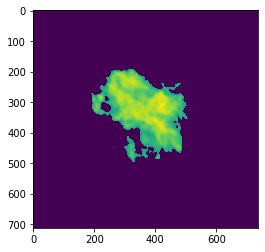

In [8]:

plt.imshow(LMLO[0])

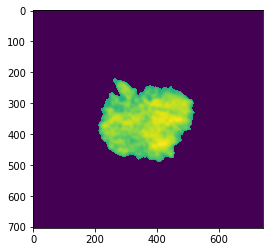

In [9]:

plt.imshow(CC[0])

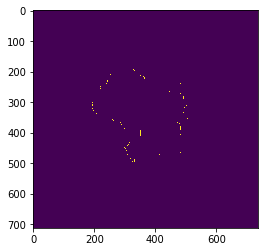

In [10]:
LMLO_edge = np.zeros((LMLO[1],LMLO[2]))
for k in range(0, LMLO[1]):
    for i in range(0, LMLO[2]):
        if LMLO[0][k,i] > 0:
            LMLO_edge[k,i] = 1
            break
            
for k in reversed(range(0, LMLO[1])):
    for i in reversed(range(0, LMLO[2])):
        if LMLO[0][k,i] > 0:
            LMLO_edge[k,i] = 1
            break
plt.imshow(LMLO_edge)

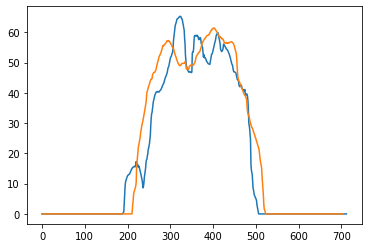

In [18]:
def line_analysis(values):
    line = []
    for ii in range(len(values)):
        if values[ii]> 0:
            line.append(ii)
            break
    for ii in reversed(range(len(values))):
        if values[ii]> 0:
            line.append(ii)
            break
    return line

In [19]:
a = line_analysis(LMLO_line[1])
b = line_analysis(CC_line[1])
im_LMLO = np.zeros((LMLO[1], 500))
for ii in range(0, LMLO[1]):
    for kk in range(0,500):
        im_LMLO[ii,kk] = LMLO[0][ii,kk+100]
im_CC = np.zeros((CC[1], 500))
for ii in range(0, CC[1]):
    for kk in range(0,500):
        im_CC[ii,kk] = CC[0][ii,kk+100]


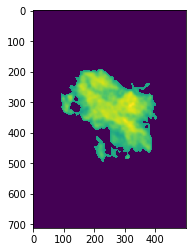

In [20]:
plt.imshow(im_LMLO)

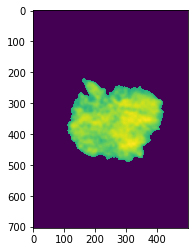

In [21]:
plt.imshow(im_CC)

In [22]:
import sys
dimesional_array = np.zeros((500,CC[1], LMLO[1]))
for k in range(0,LMLO[1]):
    for j in range(0, CC[1]):
        for i in range(0, 500):
            if CC[0][j,i] > 0 and LMLO[0][k,i] > 0:
                dimesional_array[i,j,k] = 1

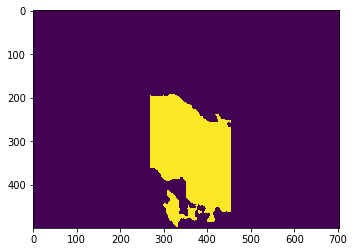

In [23]:
plt.imshow(dimesional_array[:,:,250])

In [ ]:
cluster = clustering(transfer[2], diffzml,diffxml)
    d = int(np.max(cluster))
    pos = np.zeros((1,d))
    for rr in range(1,d):
        a = area(cluster,diffzml,diffxml, rr)
        pos[:,rr] = a
    ll = np.argmax(pos)
    LMLO = cluster_reduction(cluster,transfer[2], ll, diffzml, diffxml)